In [1]:
#importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, label_binarize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
seed=12345 #fijamos la semilla de aleatorización para que sea la misma en todo el proceso
#Reemplaza con la ruta correcta y nombre de tu archivo
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Documentos/Titulo Propio/Machine Learning/SVM/Chicago_Crimes_2012_to_2017.csv' 
#convertir a data frame el archivo
data = pd.read_csv(file_path)
variables = data.columns.values 

data = data.drop(columns=[variables[0]])  ## quitamos la primera variable que no dice nada

print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}') 
data.head()
data.info()

Número de filas: 12428, Número de columnas:7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12428 entries, 0 to 12427
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  12428 non-null  object 
 1   Location Description  12390 non-null  object 
 2   Arrest                12428 non-null  bool   
 3   Beat                  12428 non-null  int64  
 4   District              12428 non-null  int64  
 5   Latitude              11825 non-null  float64
 6   Longitude             11825 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 594.8+ KB


In [11]:
num_cols=['Beat','District','Latitude','Longitude']

In [5]:
#### FE y depuración de datos ##
## Primero vemos cuantos missing tenemos en cada variable ##
data.isnull().sum()

data = data[~data["Latitude"].isnull()] ## eliminamos los datos mising 
data.isnull().sum()

data = data[~data["Location Description"].isnull()] ## eliminamos los datos mising 
data.isnull().sum()  ## sin missing ya (podriamos haberlos imputado pero en este caso no tiene sentido)

## si quiero quitarme todos de un solo paso
#data = data.dropna(axis=1)

Date                    0
Location Description    0
Arrest                  0
Beat                    0
District                0
Latitude                0
Longitude               0
dtype: int64

In [8]:
## separamos la variable target de las variables eplicativas si quisieramos hacer un modelo predictivo
variables = data.columns.values 
X = data[[variables[2], variables[3], variables[4], variables[5], variables[6],]]
y = data[variables[1]]

X.info()
X.describe()
y.value_counts()
y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11803 entries, 0 to 12427
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Arrest     11803 non-null  bool   
 1   Beat       11803 non-null  int64  
 2   District   11803 non-null  int64  
 3   Latitude   11803 non-null  float64
 4   Longitude  11803 non-null  float64
dtypes: bool(1), float64(2), int64(2)
memory usage: 472.6 KB


0    APARTMENT
1    RESIDENCE
2       STREET
3     SIDEWALK
4    RESIDENCE
Name: Location Description, dtype: object

In [10]:
# Se generan dummies para las variables no continuas
## se puede estudiar reducir el numero de categorias para la variable Localizacion
data= data.rename({'Location Description': 'Location'}, axis=1)
data['Location'] = data.Location.apply(lambda x: x if x in ['STREET','RESIDENCE','APARTMENT','SIDEWALK', 'PARKING LOT/GARAGE(NON.RESID.)'] else 'Otros')

table_location=pd.DataFrame(data["Location"].value_counts())
print(table_location)


# Creamos dummies solo para la red, en el resto sea realizará en el pipeline
data_dummies = pd.get_dummies(data,columns=['Location'], drop_first= True)
data_dummies.head()

## separamos la variable target de las variables eplicativas 
variables = data_dummies.columns.values 
X = data_dummies.drop('Arrest', axis=1)
y = data_dummies["Arrest"]

                                Location
Otros                               4333
STREET                              2653
RESIDENCE                           1886
APARTMENT                           1478
SIDEWALK                            1124
PARKING LOT/GARAGE(NON.RESID.)       329


In [12]:
#Normalizar variables numericas
#Si se quisieran estandarizar, scaler=StandardScaler()
scaler = MinMaxScaler() #selecciona el transformador
X = df[num_cols] #selecciona las variables numéricas que se quieren transformar y las guarda en un nuevo dataframe
X_scale = pd.DataFrame(scaler.fit_transform(X)) #guarda el resultado de la transformación de las variables de X en X_scale
X_scale.columns = X.columns #para simplificar los nombres, asigna a las columnas de X_scale los nombres de las variables de X_num
df[num_cols] = X_scale

In [21]:
X = df[['Beat','District']] #en X las variables ya están normalizadas y con dummies
y = df['Arrest']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
red = MLPClassifier()
#definimos los parámetros que queremos tunear
params = {
    'max_iter': [600],
    'hidden_layer_sizes': [5,7,9],
    'activation': ['tanh','relu'],
    'alpha': [0.001,0.0001]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
# cv = crossvalidation con n folds con todas las combinaciones de parámetros
grid_search = GridSearchCV(estimator=red, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')

#ajusta en entrenamiento con todas las combinaciones
grid_search.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetri

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetri

GridSearchCV(cv=4, estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.001, 0.0001],
                         'hidden_layer_sizes': [5, 7, 9], 'max_iter': [600]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [22]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search.cv_results_)
# Mostrar resultados
print("Resultados de Grid Search:")
print(results[['params', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 'mean_test_f1_macro']])
#print(results) #para ver todos los atributos obtenidos y entender cómo usarlos

# Obtener el mejor modelo (en cuanto a optimización del criterio)
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)

Resultados de Grid Search:
                                               params  mean_test_accuracy  \
0   {'activation': 'tanh', 'alpha': 0.001, 'hidden...            0.770469   
1   {'activation': 'tanh', 'alpha': 0.001, 'hidden...            0.770469   
2   {'activation': 'tanh', 'alpha': 0.001, 'hidden...            0.770469   
3   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...            0.770469   
4   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...            0.770469   
5   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...            0.770469   
6   {'activation': 'relu', 'alpha': 0.001, 'hidden...            0.770469   
7   {'activation': 'relu', 'alpha': 0.001, 'hidden...            0.770469   
8   {'activation': 'relu', 'alpha': 0.001, 'hidden...            0.770469   
9   {'activation': 'relu', 'alpha': 0.0001, 'hidde...            0.770469   
10  {'activation': 'relu', 'alpha': 0.0001, 'hidde...            0.770469   
11  {'activation': 'relu', 'alpha': 0.0001, 'hidd

In [23]:
# se seleccionan los modelos candidatos, y analiza su robustez a lo largo de cross validation.
ac_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]
ac_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[5]
ac_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[8]

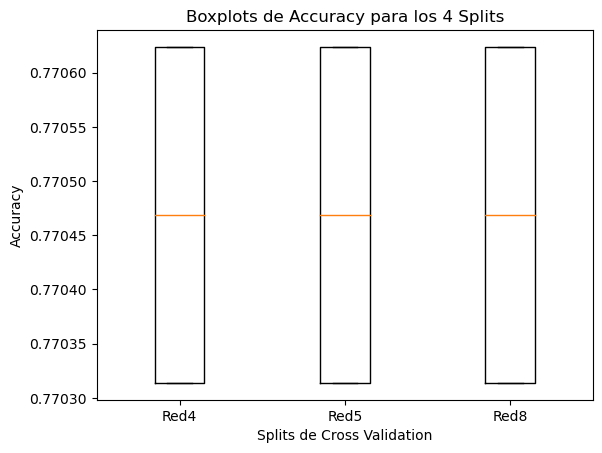

In [24]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([ac_1.values,ac_2.values,ac_3.values], labels = ['Red4','Red5','Red8'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Área bajo la curva ROC (AUC) para la red 4 en test: 0.52


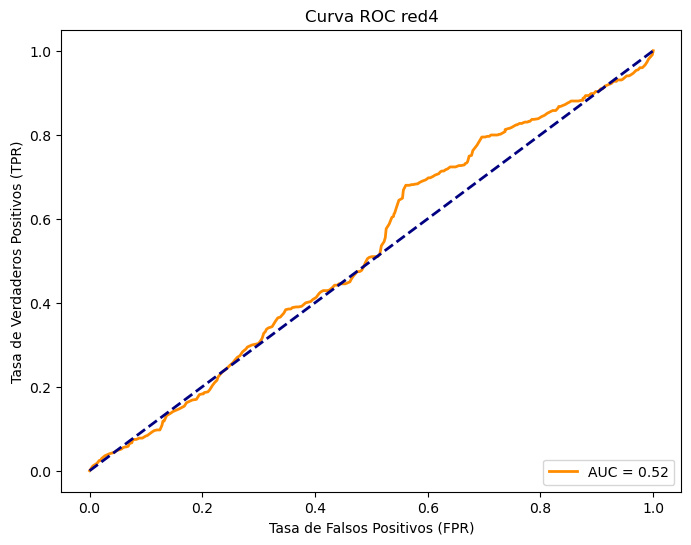

In [27]:
#analizar y reentrenar redes candidatas AUC
X = df[['Beat','District']] #en X las variables ya están normalizadas y con dummies
y = df['Arrest']
y_auc = pd.get_dummies(y,drop_first=True) #para calcular el AUC, y debe ser numérica

X_train, X_test, y_train, y_test = train_test_split(X, y_auc, test_size=0.2, random_state=seed)


red4 = MLPClassifier(**results.iloc[4].params)
red5 = MLPClassifier(**results.iloc[5].params)
red8 = MLPClassifier(**results.iloc[8].params)

# Ajustamos
red4.fit(X_test, y_test)
red5.fit(X_test, y_test)
red8.fit(X_test, y_test)


# Calculamos las predicciones en test, en términos de probabilidad para poder dibujar el AUC
y_pred4 = red4.predict_proba(X_test)[:,1]
y_pred5 = red5.predict_proba(X_test)[:,1]
y_pred8 = red8.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC) para la red 4 en test: {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC red4')
plt.legend(loc="lower right")
plt.show()